# Analyse factorielle des correspondances: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )




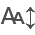

In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

from fanalysis.ca import CA 

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [5]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            ( GROUP_CONCAT(DISTINCT ?genderLabel; separator=", ") AS ?genders ) 
            ( GROUP_CONCAT(DISTINCT ?countryLabel; separator=", ") AS ?countries )
            ( GROUP_CONCAT(DISTINCT ?continentLabel; separator=", ") AS ?continents )
            ( GROUP_CONCAT(DISTINCT ?occupationLabel; separator=", ") AS ?occupations )
            ( GROUP_CONCAT(DISTINCT ?fieldLabel; separator=", ") AS ?fields )
WHERE {
    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {?s wdt:P21 ?gender;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?gender rdfs:label ?genderLabel.
        OPTIONAL {
        ?country rdfs:label ?countryLabel.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        FILTER ( ?continent NOT IN ( wd:Q3960, wd:Q538))}
        OPTIONAL {  ?s wdt:P106 ?occupation.
                    ?occupation rdfs:label ?occupationLabel.}
        OPTIONAL {  ?s wdt:P101 ?field.
                    ?field rdfs:label ?fieldLabel.}

        ## Excluding Australia and Oceania insular
        # Eurasia : wd:Q5401 
        
          }
}
GROUP BY ?s
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [7]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

23692


[['http://www.wikidata.org/entity/Q97193482',
  'Q97193482',
  '1941',
  'male',
  'Soviet Union, Ukraine',
  'Asia, Europe',
  'physicist',
  ''],
 ['http://www.wikidata.org/entity/Q4511380',
  'Anita Goel',
  '1973',
  'female',
  'India, United States',
  'Asia, North America',
  'physicist, biophysicist',
  ''],
 ['http://www.wikidata.org/entity/Q4706857',
  'Alan Herries Wilson',
  '1906',
  'male',
  'United Kingdom',
  'Europe',
  'physicist, mathematician',
  '']]

In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations', 'fields']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union, Ukraine","Asia, Europe",physicist,
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India, United States","Asia, North America","physicist, biophysicist",
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"Israel, United States, Canada","Asia, North America","physicist, academic","nuclear physics, cosmology, general relativity"
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",


In [9]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [10]:
### Verify if there's just one row per person
cf_pc = pd.DataFrame(df_p.groupby('personUri').size())
# cf_pc.reset_index(inplace=True)
cf_pc.columns = ['number']
cf_pc.sort_values('number', ascending=False).head(3)

,number
personUri,
http://www.wikidata.org/entity/Q999927,1
http://www.wikidata.org/entity/Q1000193,1
http://www.wikidata.org/entity/Q1000934,1


In [11]:
### Store to CSV if you want to avoid repeating the query:
# you can then juste reload the data
f_path = 'data/df_continent_occupations_fields_20250413.csv'


In [12]:
### Store
df_p.to_csv(f_path)

In [13]:
### Read
# df_p = pd.read_csv(f_path, index_col=0)


In [14]:
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union, Ukraine","Asia, Europe",physicist,
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India, United States","Asia, North America","physicist, biophysicist",
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",


In [15]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23692 entries, 0 to 23691
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    23692 non-null  object
 1   personLabel  23692 non-null  object
 2   birthYear    23692 non-null  int64 
 3   gender       23692 non-null  object
 4   countries    23692 non-null  object
 5   continents   23692 non-null  object
 6   occupations  23692 non-null  object
 7   fields       23692 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.4+ MB


## Coder les continents et afficher leur distribution

In [16]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0           Asia, Europe
1    Asia, North America
2                 Europe
3    Asia, North America
4                 Europe
Name: continents, dtype: object


In [17]:
df_p.continents = df_p.continents.apply(lambda x : str(x))

In [18]:
def split_strip_sort (x):
    a = x.split(',')
    b = sorted([e.strip() for e in a])
    c = ','.join(b)
    return c



In [19]:
print(split_strip_sort('Asia, North America, Eurasia'))

Asia,Eurasia,North America


In [20]:
print(split_strip_sort('Asia'))

Asia


In [21]:
print(df_p.groupby(by='continents').size().sort_values(ascending=False))

continents
Europe                                  13343
North America                            4248
Asia                                     2055
Asia, Europe                             1828
Asia, Eurasia, North America, Europe      416
North America, Europe                     394
South America                             389
Oceania                                   288
Eurasia, North America                    192
Africa                                    139
Asia, North America                        92
Eurasia, North America, Europe             80
Asia, North America, Europe                61
Europe, Oceania                            38
South America, Europe                      22
Africa, Europe                             17
Asia, Eurasia, Europe                      16
Asia, Africa, Europe                       14
South America, North America               13
North America, Oceania                     11
                                            8
Africa, North America  

In [22]:
## Mettre les pays en order alphabétique
df_p.continents = df_p['continents'].apply(lambda x: split_strip_sort(x))
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union, Ukraine","Asia,Europe",physicist,
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India, United States","Asia,North America","physicist, biophysicist",
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"Israel, United States, Canada","Asia,North America","physicist, academic","nuclear physics, cosmology, general relativity"
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",


In [23]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                                       0
continents                              
Europe                             13343
North America                       4248
Asia                                2055
Asia,Europe                         1828
Asia,Eurasia,Europe,North America    416
Europe,North America                 394
South America                        389
Oceania                              288
Eurasia,North America                192
Africa                               139


In [24]:
## Mettre les pays en order alphabétique
df_p.countries = df_p.countries.apply(lambda x: split_strip_sort(x))
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union,Ukraine","Asia,Europe",physicist,
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India,United States","Asia,North America","physicist, biophysicist",
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"Canada,Israel,United States","Asia,North America","physicist, academic","nuclear physics, cosmology, general relativity"
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",


In [25]:
### Regrouper et compter
df_countriesCode = df_p.groupby('countries').size()
df_countriesCode.columns=['effectif']
df_countriesCode = pd.DataFrame(df_countriesCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_countriesCode.iloc[:40])



                                                       0
countries                                               
United States                                       3773
Germany                                             2371
France                                              1480
Poland                                              1043
Russia,Soviet Union                                  898
United Kingdom                                       762
Italy                                                689
Japan                                                454
Hungary                                              438
Spain                                                432
Kingdom of the Netherlands                           385
Soviet Union                                         384
Sweden                                               344
Italy,Kingdom of Italy                               343
Austria                                              342
Canada                         

In [26]:
### How to code the continent of Russians
df_p[df_p.countries.str.contains('Russi')].sort_values(by='birthYear').tail(10)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
18715,http://www.wikidata.org/entity/Q86694290,Andrey A. Kuznetsov,1990,male,Russia,Europe,physicist,hydrodynamics
1150,http://www.wikidata.org/entity/Q107183155,Sergey D. Mandrykin,1993,male,Russia,Europe,physicist,magnetohydrodynamics
15491,http://www.wikidata.org/entity/Q107064401,Gennady Losev,1993,male,Russia,Europe,physicist,magnetohydrodynamics
6864,http://www.wikidata.org/entity/Q71316105,Ivan Volodin,1994,male,Russia,Europe,"chess player, programmer, physicist",hydrodynamics
17017,http://www.wikidata.org/entity/Q16668276,Vadim Kuznetsov,2000,male,"Russia,Soviet Union","Asia,Europe",physicist,
18388,http://www.wikidata.org/entity/Q5917820,Jurij B. Kolesnik,2000,male,"Russia,Soviet Union","Asia,Europe","physicist, astronomer",
19402,http://www.wikidata.org/entity/Q48358871,Vladimir V. Zhivonitko,2000,male,Russia,Europe,"physicist, chemist",
15947,http://www.wikidata.org/entity/Q15453849,Eugene Bogomolny,2000,male,Russia,Europe,physicist,
17073,http://www.wikidata.org/entity/Q112033427,Kirill Kliuchinskii,2000,male,Russia,Europe,student,astronomy
13487,http://www.wikidata.org/entity/Q2498733,Elena V. Pitjeva,2000,female,Russia,Europe,astronomer,


In [ ]:
### 
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
97,http://www.wikidata.org/entity/Q2573136,Wilhelm Heinrich Heraeus,1900,male,Germany,Europe,"physicist, entrepreneur, chemist",,Europe
98,http://www.wikidata.org/entity/Q1730238,Karl Albert Hasselbalch,1874,male,Kingdom of Denmark,Europe,"physicist, chemist",,Europe
99,http://www.wikidata.org/entity/Q4131361,Andrey Gagarin,1856,male,"Russian Empire,Russian Soviet Federative Socia...","Eurasia,North America","pedagogue, mathematician, engineer",physics,Eurasia
100,http://www.wikidata.org/entity/Q107844507,Stefania Gori,1983,female,Italy,Europe,physicist,,Europe


In [ ]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
111,http://www.wikidata.org/entity/Q4511457,Luise Meyer-Schützmeister,1915,female,Germany,Europe,"physicist, nuclear physicist",,Europe
112,http://www.wikidata.org/entity/Q57024819,Hannes Pichler,1986,male,"Austria,Italy",Europe,"researcher, physicist",,Europe
113,http://www.wikidata.org/entity/Q126718262,Zhou Lian,1940,male,People's Republic of China,Asia,"researcher, physicist",,Asia
114,http://www.wikidata.org/entity/Q7085825,Ole Colbjørnsen,1897,male,Norway,Europe,"physicist, journalist, politician, economist",,Europe
115,http://www.wikidata.org/entity/Q59624350,Alberto Carlini,1965,male,Italy,Europe,physicist,,Europe
116,http://www.wikidata.org/entity/Q95361999,František Doutlík,1880,male,Czechoslovakia,Europe,"musician, chronicler, teacher","astronomy, educational system",Europe
117,http://www.wikidata.org/entity/Q17119374,Eliza Wilbur,1851,female,United States,North America,"inventor, astronomer",,NorthAmerica


In [29]:
### Personnes trouvées grâce à leur champ, 'field'
# https://stackoverflow.com/questions/21055068/reversal-of-string-contains-in-python-pandas
dff = df_p[~(df_p.occupations.str.contains("astronomer|physicist"))]
print('Effectif: ', len(dff), '\n')
print(dff.head(2).personUri)
dff.head()

Effectif:  437 

94      http://www.wikidata.org/entity/Q72055
99    http://www.wikidata.org/entity/Q4131361
Name: personUri, dtype: object


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
94,http://www.wikidata.org/entity/Q72055,Albrecht Wellmer,1933,male,Germany,Europe,"philosopher, university teacher, sociologist","mathematics, physics"
99,http://www.wikidata.org/entity/Q4131361,Andrey Gagarin,1856,male,"Russian Empire,Russian Soviet Federative Socia...","Eurasia,North America","pedagogue, mathematician, engineer",physics
116,http://www.wikidata.org/entity/Q95361999,František Doutlík,1880,male,Czechoslovakia,Europe,"musician, chronicler, teacher","astronomy, educational system"
128,http://www.wikidata.org/entity/Q4444381,Vladimir Strunin,1953,male,Russia,Europe,scientist,physics
154,http://www.wikidata.org/entity/Q114191385,Q114191385,1946,male,"Belarus,Soviet Union","Asia,Europe","university teacher, scientist","optics, physics"


In [30]:
### Problème du contienent d'appartenance des russes,
# commetn coder?
dfr = df_p[df_p.countries.str.contains('Russi|Sovi')]
print(len(dfr))

2871


In [ ]:
show(dfr,  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", 
     columnDefs=[{"className": "dt-left", "targets": "_all"}],
     search={"regex": True, "caseInsensitive": True},
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading ITables v2.0.1 from the init_notebook_mode cell... (need help?)


In [31]:
dfea = df_p[df_p.continents.str.contains('Euras')]
print(len(dfea))

708


In [ ]:
show(dfea,  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", 
     columnDefs=[{"className": "dt-left", "targets": "_all"}],
     search={"regex": True, "caseInsensitive": True},
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading ITables v2.0.1 from the init_notebook_mode cell... (need help?)


In [47]:
### Créer une fonction de codage
def codeContinents(continents, countries):
    
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    if 'ussi' in countries or 'oviet' in countries:
        output = 'Eurasia'
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'Asia,Europe' in continents:
        output = 'Eurasia'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [48]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents'], x['countries']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union,Ukraine","Asia,Europe",physicist,,Eurasia
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India,United States","Asia,North America","physicist, biophysicist",,Asia
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe


In [49]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode)
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode.sort_values('effectif',ascending = False))



              effectif
contCode              
Europe           13324
NorthAmerica      4261
Eurasia           3063
Asia              2138
SouthAmerica       389
Oceania            342
Africa             167
Missing              8


In [50]:
 
### Regrouper et compter les personnes issues de Russie
# le codage 
df_contCode = df_p[df_p.countries.str.contains('ussi|oviet')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



          effectif
contCode          
Eurasia       3010


In [51]:
df_p[(df_p.countries.str.contains('ussi|oviet')) & (df_p.contCode.str.contains('Europe'))].head(10)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode


### Continents: codage par période de vingt-cinq ans

In [52]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 2025, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1901, 1926, 1951, 1976, 2001] 10


In [53]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [54]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union,Ukraine","Asia,Europe",physicist,,Eurasia,1926-1950
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India,United States","Asia,North America","physicist, biophysicist",,Asia,1951-1975
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe,1901-1925


In [55]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1751-1775     254
1776-1800     328
1801-1825     534
1826-1850     812
1851-1875    1312
1876-1900    1918
1901-1925    4216
1926-1950    8136
1951-1975    4960
1976-2000    1222
dtype: int64


## Analyse bivariée: périodes, continents

In [56]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1751-1775,212,26,4,8,0,1,1,254
1776-1800,257,47,17,3,1,2,1,328
1801-1825,390,83,47,7,2,2,3,534
1826-1850,574,117,97,6,2,10,5,812
1851-1875,873,169,201,24,6,27,12,1312
1876-1900,1231,234,328,84,9,20,12,1918
1901-1925,1957,689,1022,385,21,82,59,4216
1926-1950,4072,1266,1567,916,46,118,148,8136
1951-1975,2980,371,784,596,49,68,111,4960


In [57]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


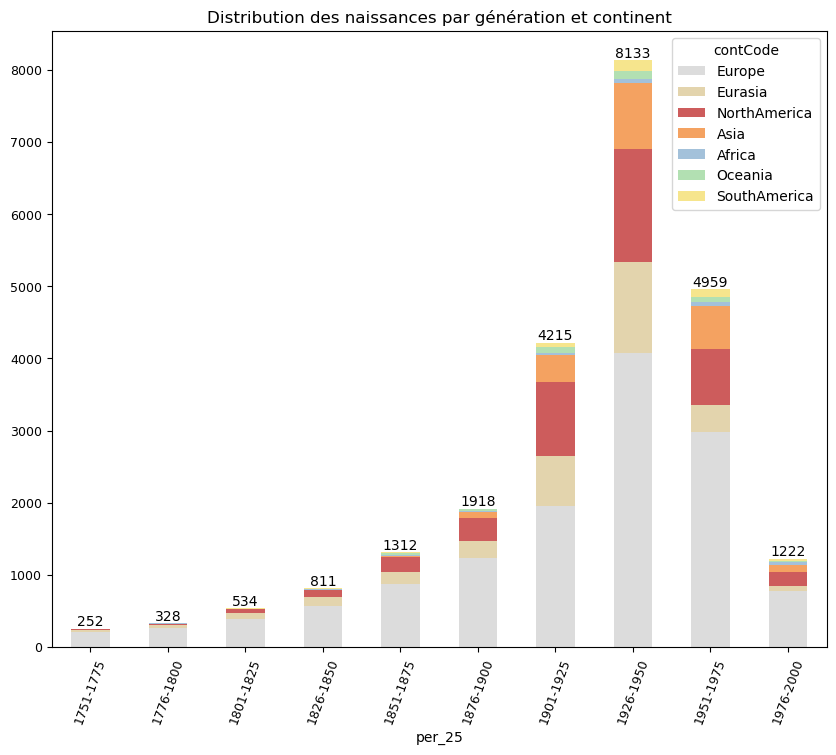

In [58]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

### Créer les fonctions

In [59]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [60]:
ct_wm = ddf.iloc[3:-2,:-1].copy(deep=True)
ct_wm

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,574,117,97,6,2,10,5
1851-1875,873,169,201,24,6,27,12
1876-1900,1231,234,328,84,9,20,12
1901-1925,1957,689,1022,385,21,82,59
1926-1950,4072,1266,1567,916,46,118,148
1951-1975,2980,371,784,596,49,68,111


In [61]:
bivariee_stats(ct_wm)

Chi2 : 851.28 , dof : 30
p-value : 1.0643685508053283e-159
phi2 = inertie (variance totale) : 0.03987644198468521
Cramer:  0.08930447019571328


In [62]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

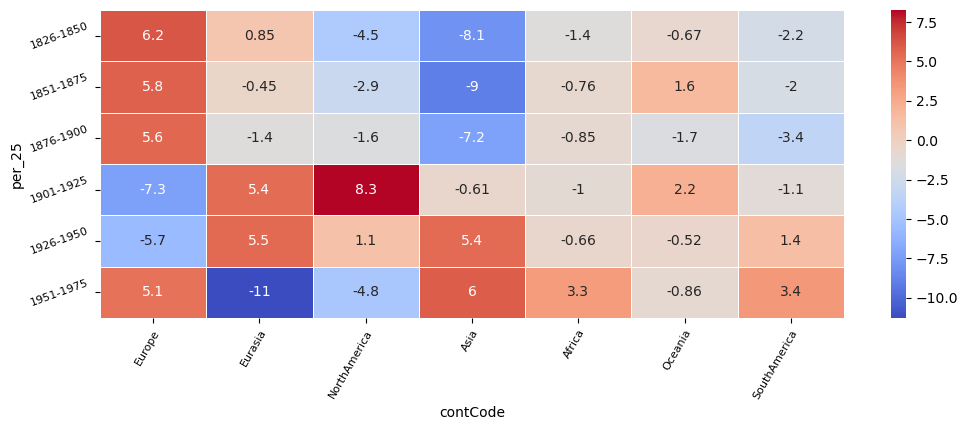

In [63]:
pp = plot_chi2_residuals(ct_wm, figsize=(12, 4))

### Analyse factorielle des correspondances (AFC)

In [64]:
ct_wm

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,574,117,97,6,2,10,5
1851-1875,873,169,201,24,6,27,12
1876-1900,1231,234,328,84,9,20,12
1901-1925,1957,689,1022,385,21,82,59
1926-1950,4072,1266,1567,916,46,118,148
1951-1975,2980,371,784,596,49,68,111


In [65]:
afc = CA(row_labels=ct_wm.index,col_labels=ct_wm.columns)
afc.fit(ct_wm.values)

CA(col_labels=Index(['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania',
       'SouthAmerica'],
      dtype='object', name='contCode'),
   row_labels=Index(['1826-1850', '1851-1875', '1876-1900', '1901-1925', '1926-1950',
       '1951-1975'],
      dtype='object', name='per_25'))

In [66]:
def print_eigenvalue(afc):

    eig = pd.DataFrame(afc.eig_)

    r1 = round(eig.iloc[0], 3)
    r2 = round(eig.iloc[2], 2)
    s=list(range(1,len(r1)+1))
    r1.index=s
    r2.index=s

    # https://www.statology.org/pandas-subplots/
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    ax1 = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
    ax2 = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")


    ax1.bar_label(ax1.containers[0])
    ax2.bar_label(ax2.containers[0])


    # Met les valeurs xticks en vertical
    fig.autofmt_xdate(rotation=0)
    plt.show()

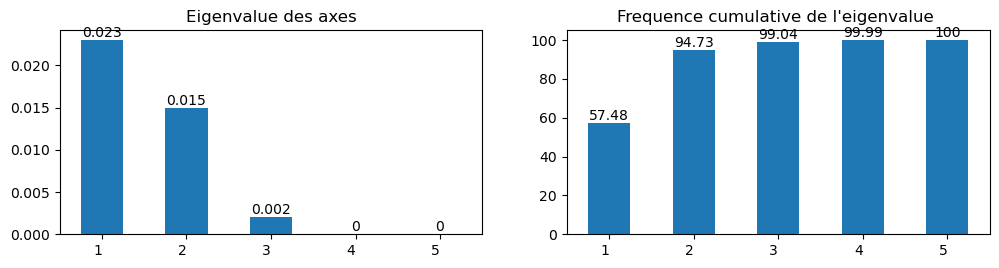

In [67]:
print_eigenvalue(afc)

In [68]:
def contributions_colonnes(afc):
    
    # Informations sur les contributions des colonnes
    df = afc.col_topandas()[['col_contrib_dim1',
                            'col_contrib_dim2',
                            'col_contrib_dim3']]

    r1 = df.iloc[:,0]
    r2 = df.iloc[:,1]
    r3 = df.iloc[:,2]

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

    r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
    r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
    r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

    ### Rows
    df = afc.row_topandas()[['row_contrib_dim1',
                            'row_contrib_dim2',
                            'row_contrib_dim3']]
    r1 = df.iloc[:,0]
    r2 = df.iloc[:,1]
    r3 = df.iloc[:,2]

    r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
    r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
    r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

    plt.tight_layout()
    plt.show()


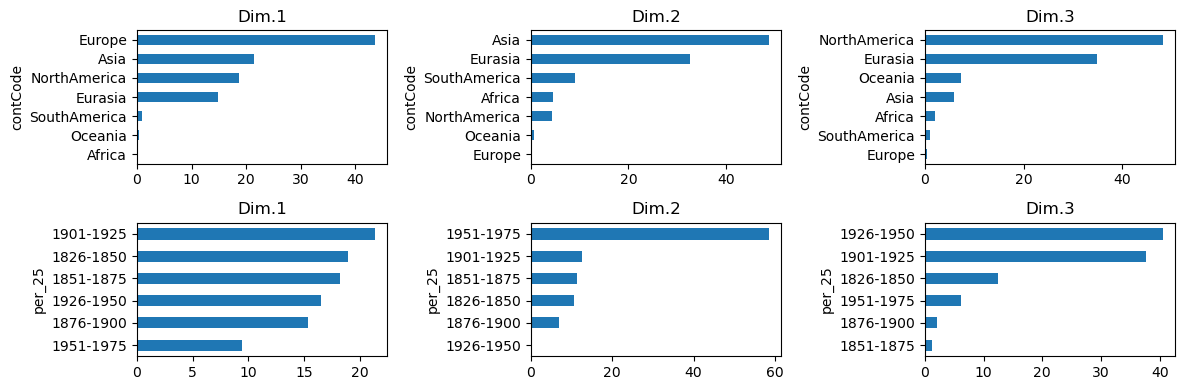

In [69]:
contributions_colonnes(afc)

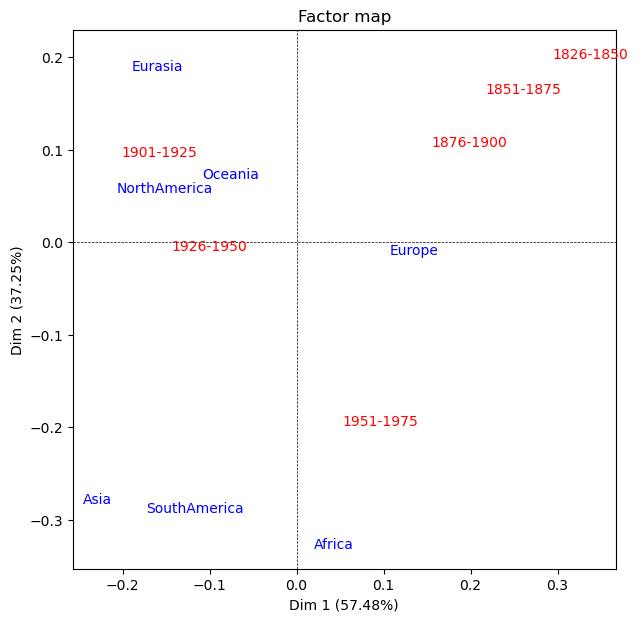

In [70]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

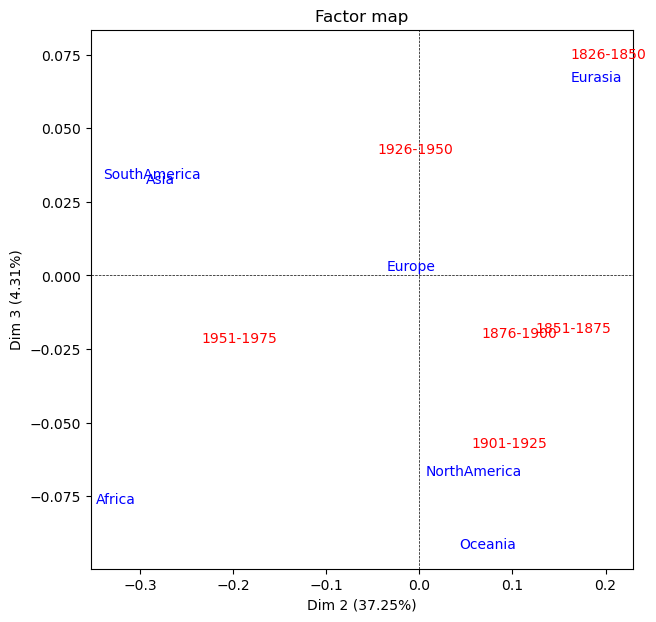

In [71]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(7,7))

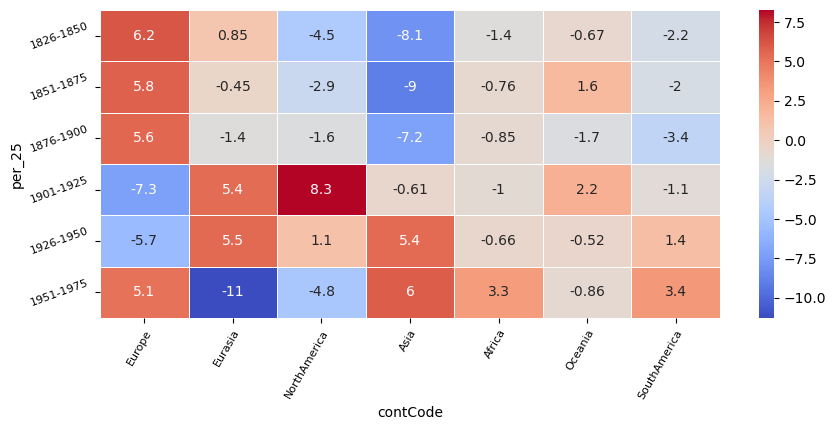

In [72]:
pp = plot_chi2_residuals(ct_wm, figsize=(10, 4))

## Continent et genre

In [73]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union,Ukraine","Asia,Europe",physicist,,Eurasia,1926-1950
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India,United States","Asia,North America","physicist, biophysicist",,Asia,1951-1975
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe,1901-1925
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"Canada,Israel,United States","Asia,North America","physicist, academic","nuclear physics, cosmology, general relativity",Asia,1901-1925
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",,Europe,1926-1950


In [74]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[(df_p.contCode!='Missing') & (df_p.gender.isin(['female', 'male']))]\
            [[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,41,159,150,1166,482,37,87,2122
male,126,1976,2913,12155,3773,302,302,21547
Total,167,2135,3063,13321,4255,339,389,23669


### Genre et continent par époque

In [75]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union,Ukraine","Asia,Europe",physicist,,Eurasia,1926-1950,Eurasia_male
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India,United States","Asia,North America","physicist, biophysicist",,Asia,1951-1975,Asia_female
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe,1901-1925,Europe_male
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"Canada,Israel,United States","Asia,North America","physicist, academic","nuclear physics, cosmology, general relativity",Asia,1901-1925,Asia_male
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",,Europe,1926-1950,Europe_male


In [76]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[(df_p.contCode!='Missing') & (df_p.gender.isin(['female', 'male']))]\
                [[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male,Total
per_25,,,,,,,,,,,,,,,
1751-1775,0,0,1,7,0,26,4,208,0,4,0,1,0,1,252
1776-1800,0,1,0,3,0,47,6,251,0,17,0,2,0,1,328
1801-1825,0,2,0,7,0,83,3,387,4,43,0,2,0,3,534
1826-1850,0,2,0,6,1,116,10,564,7,90,0,10,0,5,811
1851-1875,0,6,0,24,5,164,30,843,23,178,2,25,0,12,1312
1876-1900,0,9,0,84,22,212,81,1150,45,283,1,19,0,12,1918
1901-1925,3,18,27,357,38,651,143,1814,72,950,6,76,13,46,4214
1926-1950,5,41,42,873,49,1217,280,3791,119,1448,8,109,26,122,8130
1951-1975,15,34,62,534,23,348,412,2567,150,632,15,51,36,75,4954


In [77]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[6:-1,:-1].copy(deep=True)
D


genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male
per_25,,,,,,,,,,,,,,
1901-1925,3,18,27,357,38,651,143,1814,72,950,6,76,13,46
1926-1950,5,41,42,873,49,1217,280,3791,119,1448,8,109,26,122
1951-1975,15,34,62,534,23,348,412,2567,150,632,15,51,36,75
1976-2000,18,13,27,81,12,49,197,580,62,128,5,7,12,25


In [78]:
### Exclure l'Afrique
D = ddgcp.iloc[6:-1,2:-1].copy(deep=True)
D


genre_cont,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male
per_25,,,,,,,,,,,,
1901-1925,27,357,38,651,143,1814,72,950,6,76,13,46
1926-1950,42,873,49,1217,280,3791,119,1448,8,109,26,122
1951-1975,62,534,23,348,412,2567,150,632,15,51,36,75
1976-2000,27,81,12,49,197,580,62,128,5,7,12,25


In [79]:
## Appliquer la fonction
bivariee_stats(D)

Chi2 : 1114.3 , dof : 33
p-value : 7.795328317610967e-213
phi2 = inertie (variance totale) : 0.06066875194729768
Cramer:  0.1422073040169382


### AFC

In [80]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['Asia_female', 'Asia_male', 'Eurasia_female', 'Eurasia_male',
       'Europe_female', 'Europe_male', 'NorthAmerica_female',
       'NorthAmerica_male', 'Oceania_female', 'Oceania_male',
       'SouthAmerica_female', 'SouthAmerica_male'],
      dtype='object', name='genre_cont'),
   row_labels=Index(['1901-1925', '1926-1950', '1951-1975', '1976-2000'], dtype='object', name='per_25'))

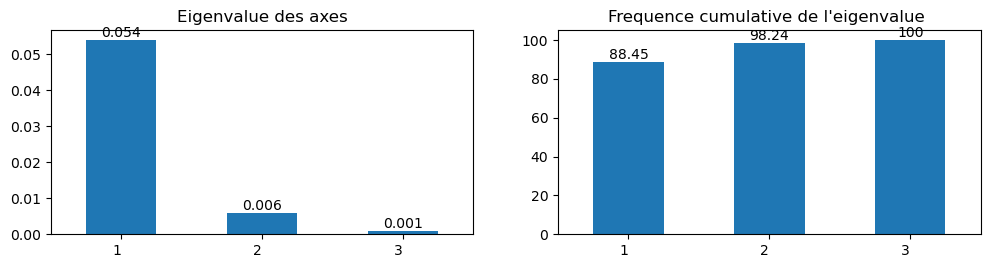

In [81]:
print_eigenvalue(afc)

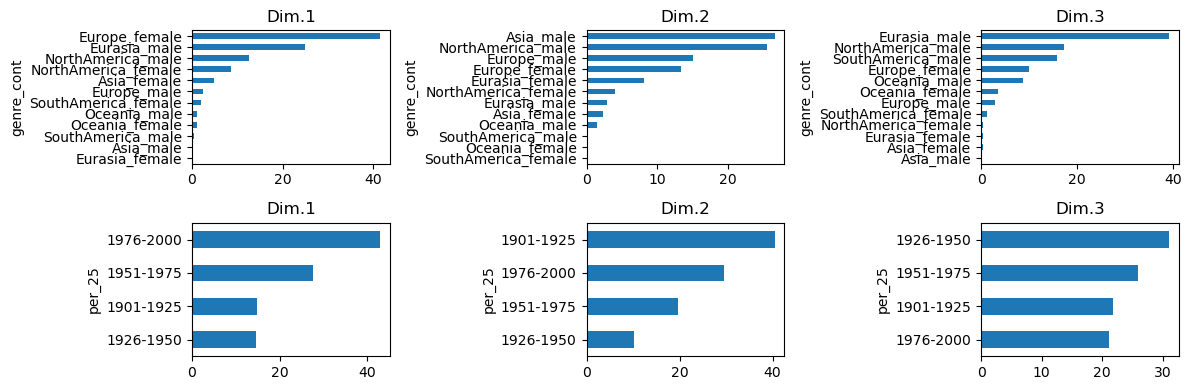

In [82]:
contributions_colonnes(afc)

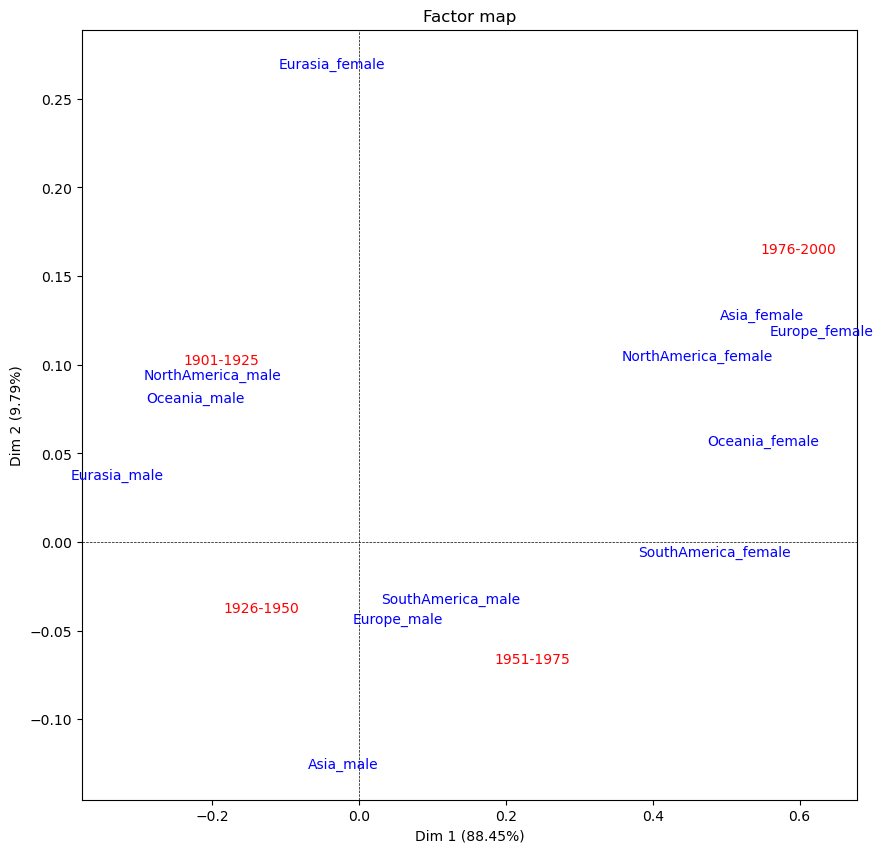

In [83]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(10,10))

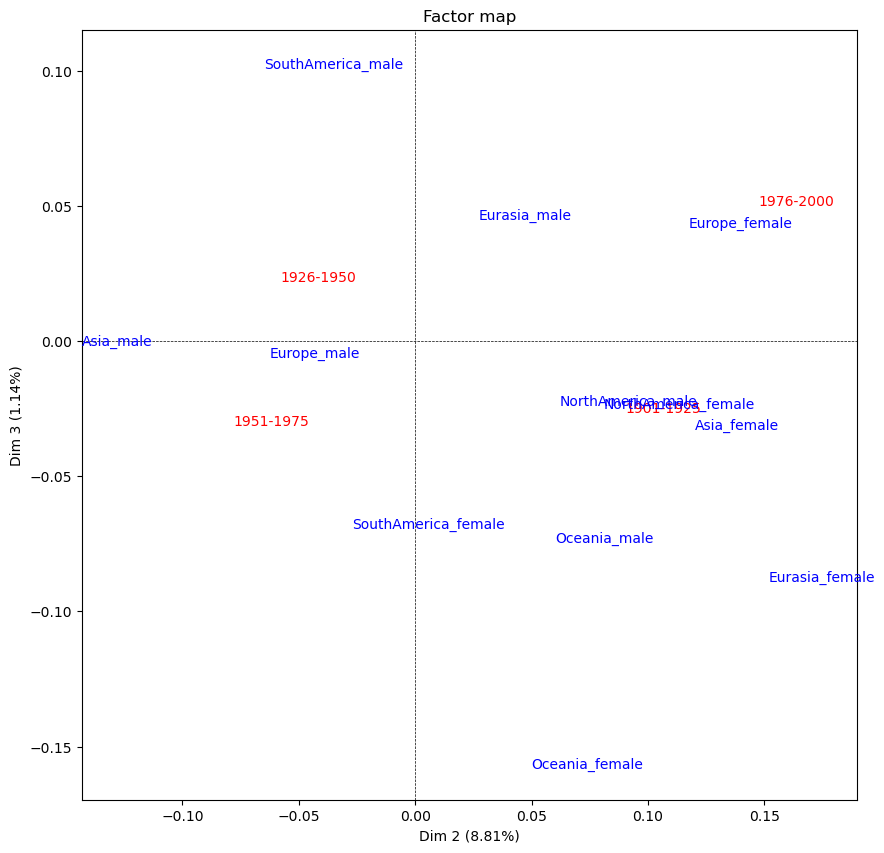

In [ ]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(10,10))

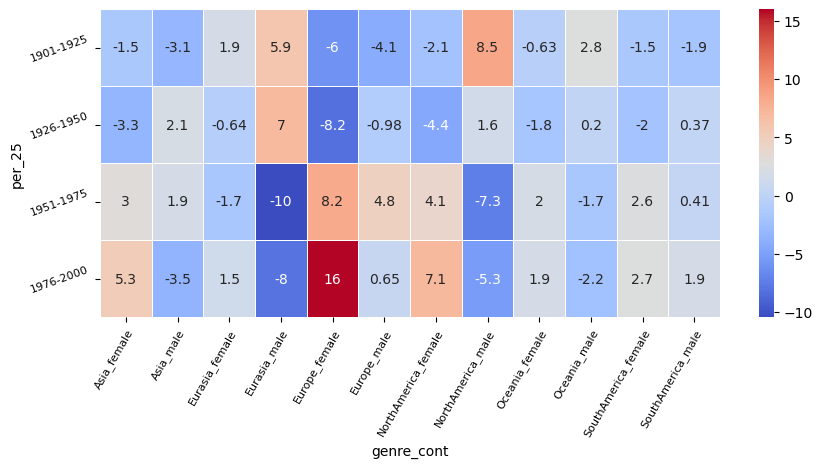

In [84]:
pp = plot_chi2_residuals(D, figsize=(10, 4))

## Continent et discipline

In [85]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union,Ukraine","Asia,Europe",physicist,,Eurasia,1926-1950,Eurasia_male
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India,United States","Asia,North America","physicist, biophysicist",,Asia,1951-1975,Asia_female
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe,1901-1925,Europe_male
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"Canada,Israel,United States","Asia,North America","physicist, academic","nuclear physics, cosmology, general relativity",Asia,1901-1925,Asia_male
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",,Europe,1926-1950,Europe_male


In [86]:
def code_discipline(col1, col2):
    if  'astronomer' in col1\
        or 'astronomy' in col2:
        output = 'astronomy'
    elif 'physicist' in col1\
        or 'physics' in col2:
        output = 'physics'
    else:
        output = 'other'
    return output    


In [87]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.occupations, x.fields), axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union,Ukraine","Asia,Europe",physicist,,Eurasia,1926-1950,Eurasia_male,physics
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India,United States","Asia,North America","physicist, biophysicist",,Asia,1951-1975,Asia_female,physics
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe,1901-1925,Europe_male,physics
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"Canada,Israel,United States","Asia,North America","physicist, academic","nuclear physics, cosmology, general relativity",Asia,1901-1925,Asia_male,physics
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",,Europe,1926-1950,Europe_male,physics


In [88]:
df_p.groupby('code_discipline').size()

code_discipline
astronomy     5814
physics      17878
dtype: int64

In [89]:


### Tableau de contingence
X = "contCode"
Y = "code_discipline"  # "0"

dddc = df_p[(df_p.contCode!='Missing') & (df_p.gender.isin(['female', 'male']))]\
        [[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
astronomy,52,495,554,3093,1369,117,121,5801
physics,115,1640,2509,10228,2886,222,268,17868
Total,167,2135,3063,13321,4255,339,389,23669


In [90]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
astronomy,0.9,8.5,9.6,53.3,23.6,2.0,2.1,100.0
physics,0.6,9.2,14.0,57.2,16.2,1.2,1.5,100.0
Total,0.7,9.0,12.9,56.3,18.0,1.4,1.6,100.0


In [91]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


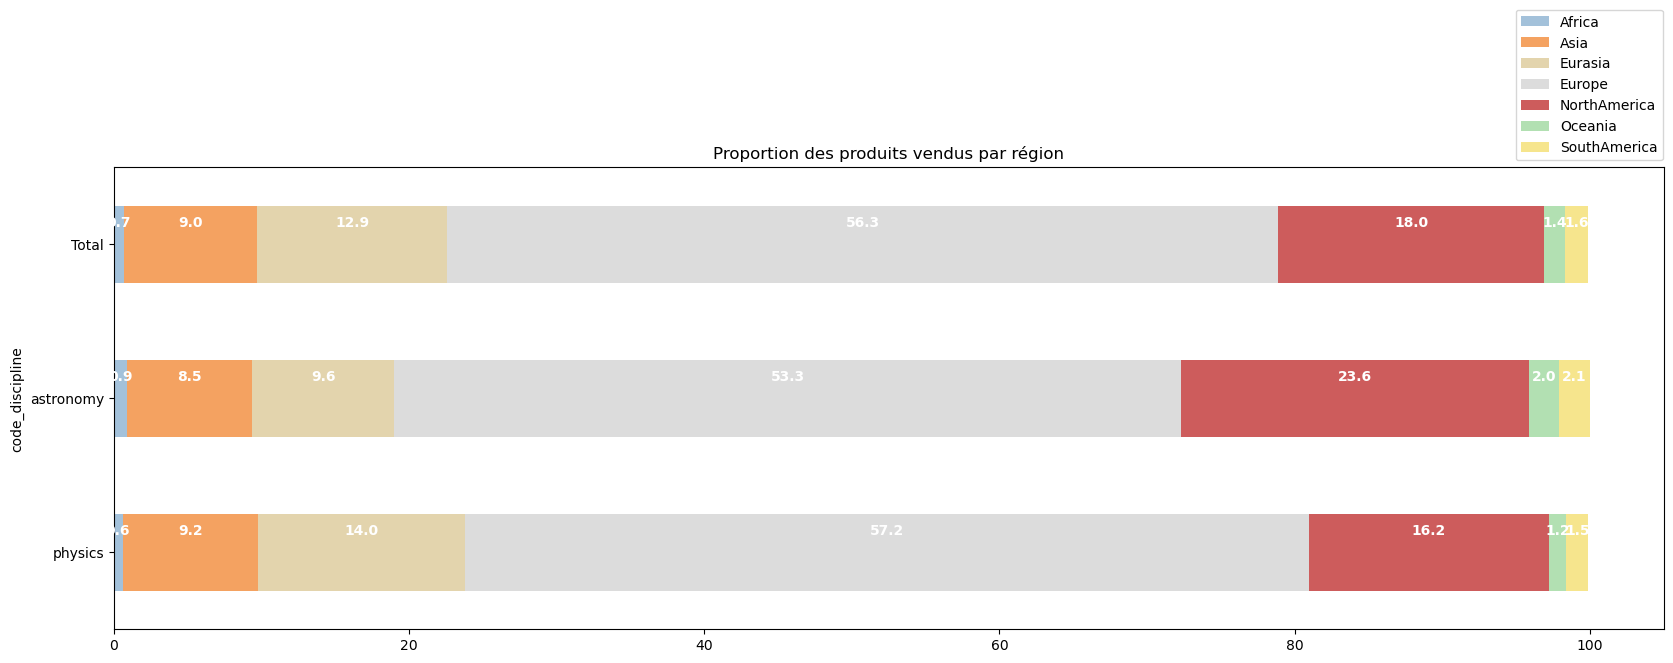

In [92]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,6), title='Proportion des produits vendus par région',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [93]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
code_discipline,,,,,,,
astronomy,52,495,554,3093,1369,117,121
physics,115,1640,2509,10228,2886,222,268


In [94]:
## Appliquer la fonction
bivariee_stats(D)

Chi2 : 248.85 , dof : 6
p-value : 7.2276212002404e-51
phi2 = inertie (variance totale) : 0.010513688803711146
Cramer:  0.10253628042654535


## Discipline et continent par époque

In [95]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union,Ukraine","Asia,Europe",physicist,,Eurasia,1926-1950,Eurasia_male,physics
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India,United States","Asia,North America","physicist, biophysicist",,Asia,1951-1975,Asia_female,physics


In [96]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Soviet Union,Ukraine","Asia,Europe",physicist,,Eurasia,1926-1950,Eurasia_male,physics,Eurasia_physics
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"India,United States","Asia,North America","physicist, biophysicist",,Asia,1951-1975,Asia_female,physics,Asia_physics


In [97]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[(df_p.contCode!='Missing') & (df_p.gender.isin(['female', 'male']))]\
            [[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_astronomy,Africa_physics,Asia_astronomy,Asia_physics,Eurasia_astronomy,Eurasia_physics,Europe_astronomy,Europe_physics,NorthAmerica_astronomy,NorthAmerica_physics,Oceania_astronomy,Oceania_physics,SouthAmerica_astronomy,SouthAmerica_physics,Total
per_25,,,,,,,,,,,,,,,
1751-1775,0,0,8,0,12,14,114,98,2,2,1,0,1,0,252
1776-1800,1,0,3,0,34,13,122,135,10,7,2,0,0,1,328
1801-1825,2,0,6,1,35,48,175,215,33,14,2,0,3,0,534
1826-1850,2,0,4,2,49,68,238,336,69,28,9,1,3,2,811
1851-1875,5,1,9,15,61,108,330,543,109,92,17,10,5,7,1312
1876-1900,6,3,24,60,76,158,323,908,113,215,6,14,7,5,1918
1901-1925,8,13,63,321,123,566,392,1565,194,828,24,58,20,39,4214
1926-1950,12,34,189,726,128,1138,606,3465,408,1159,23,94,28,120,8130
1951-1975,10,39,148,448,26,345,609,2370,346,436,24,42,32,79,4954


In [98]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[5:-1,:-1].copy(deep=True)
D


disc_cont,Africa_astronomy,Africa_physics,Asia_astronomy,Asia_physics,Eurasia_astronomy,Eurasia_physics,Europe_astronomy,Europe_physics,NorthAmerica_astronomy,NorthAmerica_physics,Oceania_astronomy,Oceania_physics,SouthAmerica_astronomy,SouthAmerica_physics
per_25,,,,,,,,,,,,,,
1876-1900,6,3,24,60,76,158,323,908,113,215,6,14,7,5
1901-1925,8,13,63,321,123,566,392,1565,194,828,24,58,20,39
1926-1950,12,34,189,726,128,1138,606,3465,408,1159,23,94,28,120
1951-1975,10,39,148,448,26,345,609,2370,346,436,24,42,32,79
1976-2000,6,25,41,67,10,51,184,593,85,105,9,3,22,15


In [99]:
## Appliquer la fonction
bivariee_stats(D)

Chi2 : 1188.67 , dof : 52
p-value : 1.1530302116737008e-214
phi2 = inertie (variance totale) : 0.05817700067235122
Cramer:  0.12059954464295379


### AFC

In [100]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['Africa_astronomy', 'Africa_physics', 'Asia_astronomy', 'Asia_physics',
       'Eurasia_astronomy', 'Eurasia_physics', 'Europe_astronomy',
       'Europe_physics', 'NorthAmerica_astronomy', 'NorthAmerica_physics',
       'Oceania_astronomy', 'Oceania_physics', 'SouthAmerica_astronomy',
       'SouthAmerica_physics'],
      dtype='object', name='disc_cont'),
   row_labels=Index(['1876-1900', '1901-1925', '1926-1950', '1951-1975', '1976-2000'], dtype='object', name='per_25'))

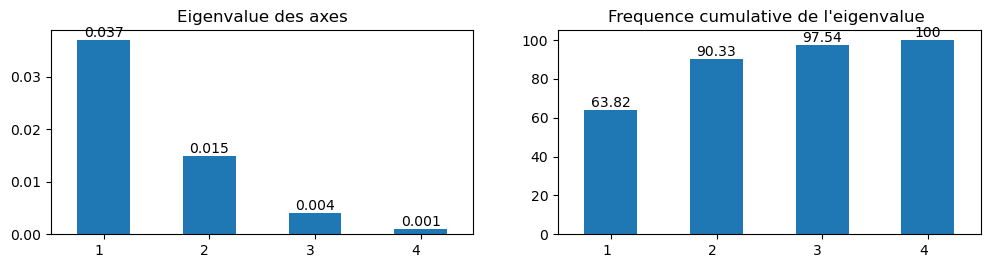

In [101]:
print_eigenvalue(afc)

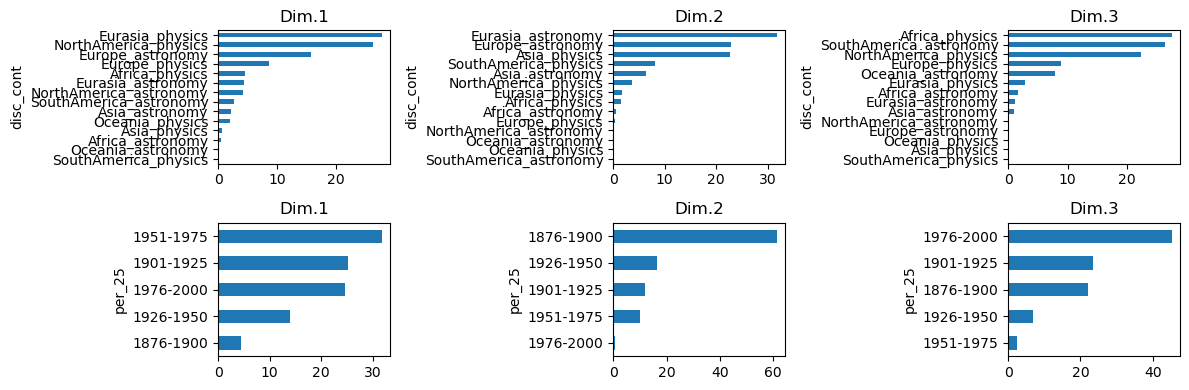

In [102]:
contributions_colonnes(afc)

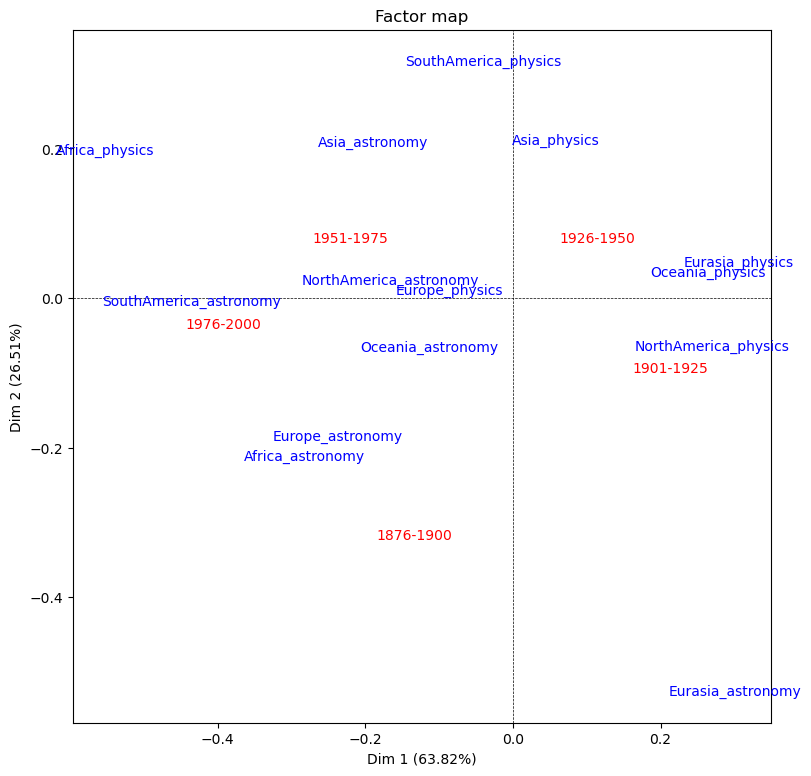

In [103]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(9,9))

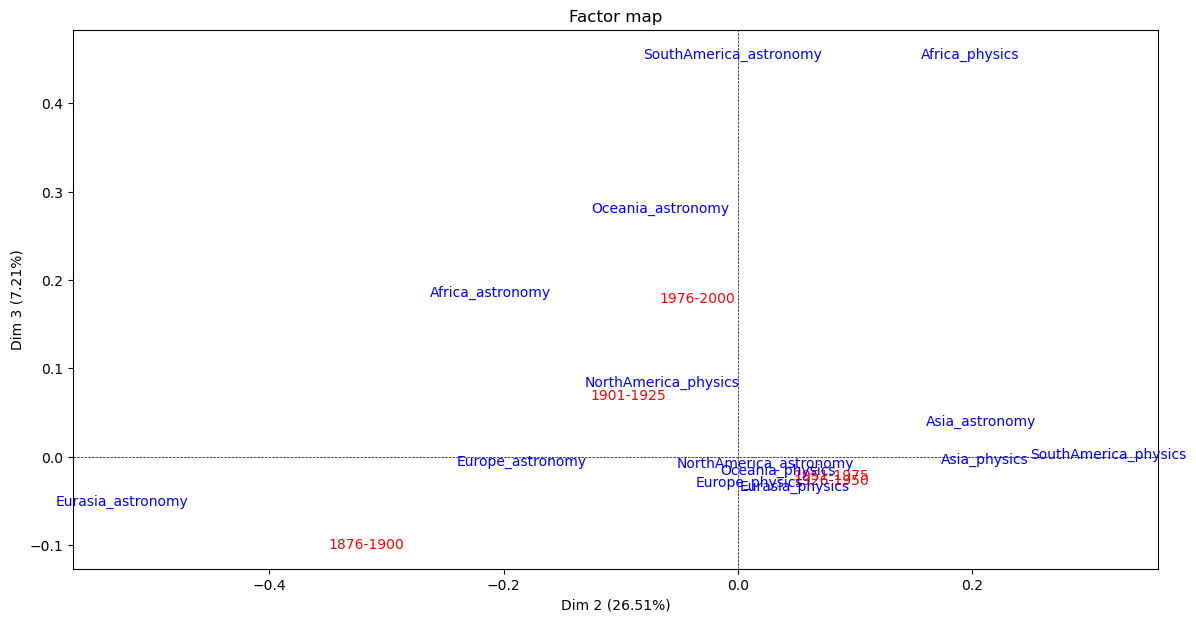

In [104]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(14,7))

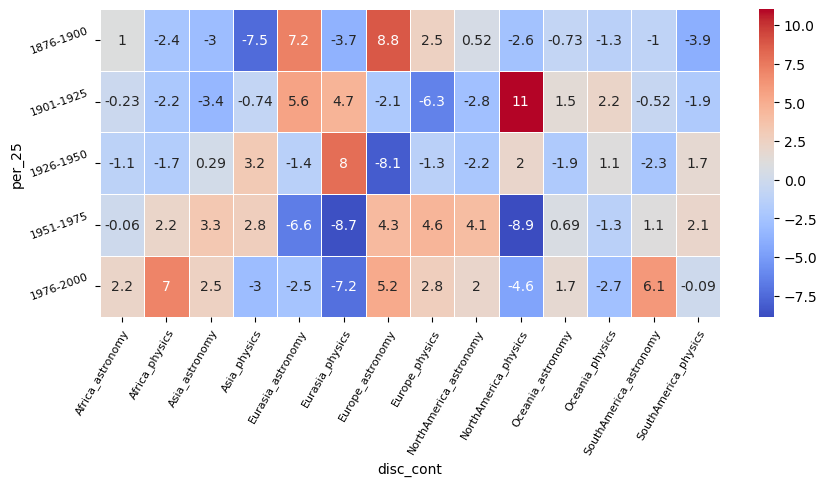

In [105]:
pp = plot_chi2_residuals(D, figsize=(10, 4))